## LSTM con 512 células y lookback de 30 (6000 épocas)

En este notebook, se lleva a cabo el entrenamiento de una red LSTM con 512 células y lookback de 30. Para esto, se hace uso de la herramienta Google Colaboratory. Se guarda el modelo y su error cuadrático médio en diferentes puntos del entrenamiento (cada 200 épocas). Finalmente, se comparan los mse y se grafícan las predicciones del modelo con menor mse. A partir de las 4000 épocas, se cambia el optimizador de Adam a RMSProp y se agrega el parámetro tamaño de batch = 64. Se obtiene un mse de 0.175097 para los datos escalado.

## Contenido

### 1. Importación de librerías y cargue del dataset
### 2. Herramientas de Google para guardar modelos en Drive
### 3. Definión funciones de creación de dataset y gráficos de los modelos
### 4. Creación y entrenamiento del modelo LSTM-512C-30Lb
### 5. Comparación del modelo y gráfico de predicciones

## 1. Importación de librerías y cargue del dataset

A continuación, se cargan las librerías necesarias para completar esta tarea:

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import decomposition
from keras.layers import Dense, LSTM
from keras.models import Sequential
%matplotlib inline

Se lee el archivo de excel que contiene la información del dataset y se convierte la columna fecha en el id de cada final.

In [5]:
dataset = pd.read_excel('./Dataset.xls')
dataset.set_index('fecha',inplace=True)
dataset = dataset.drop(dataset.columns[[0]], axis=1)
dataset.head()

,Cantidad,Volumen,BCOLOMBIA,Precio Mayor,Precio Medio,Precio Menor,Variacion,Variacion Absoluta,COLCAP,BOGOTA,OCCIDENTE,POPULAR,BBVACOL,BVC,PROTECCION,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum,Fourier3,Fourier6,Fourier9,Fourier100,ARIMA
fecha,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008-02-14,486958,7207593760,14720,14860,14801.2637,14720,0.14,20,928.67,29340,20120,297,200,29.9,36600,14468.571429,14560.000000,14613.990768,14627.916145,13.925378,583.488601,15726.977202,13393.022798,14696.852167,14719,9.596894,(23077.7896372-2047.39795493j),(23674.5437646-650.00805727j),(23945.950803-130.487624855j),(14657.7161987-17.6998958368j),14720.0
2008-02-15,177200,2612417120,14800,14900,14742.7603,14600,0.54,80,929.63,29400,20120,297,200,29.7,36600,14540.000000,14569.523810,14630.874906,14655.079016,24.204110,575.509843,15720.543495,13418.504124,14765.617389,14799,9.602315,(23037.1586527-2046.75954045j),(23584.8975715-648.262236787j),(23821.3641891-129.870353806j),(14978.1025656-27.1178367254j),14800.0
2008-02-18,41671,619473620,14980,14980,14865.8208,14800,1.22,180,944.25,29360,20120,297,200,30.7,36600,14662.857143,14611.428571,14662.044720,14706.162364,44.117644,449.725062,15510.878696,13711.978447,14908.539130,14979,9.614404,(22996.5552587-2046.02572901j),(23495.2077147-646.395558862j),(23696.6789755-129.19860656j),(15256.4954598-35.1374565661j),14980.0
2008-02-20,153372,2285441560,15000,15100,14901.2959,14740,-1.06,-160,941.38,29200,20120,297,200,30.0,36600,14762.857143,14704.761905,14691.765372,14752.203625,60.438253,373.659006,15452.079916,13957.443893,14969.513043,14999,9.615739,(22915.4357998-2044.27205648j),(23315.7211407-642.301045191j),(23447.0773391-127.692833309j),(15646.3056008-45.4210457344j),15000.0
2008-02-21,535243,8086448540,15200,15200,15107.9949,15000,1.33,200,944.38,29120,20120,297,200,29.8,36600,14857.142857,14780.952381,14735.849445,14822.169663,86.320217,326.246597,15433.445575,14128.459187,15123.171014,15199,9.628985,(22874.9220125-2043.25227713j),(23225.9365058-640.073972798j),(23322.1932437-126.859438924j),(15745.9082169-47.1547456557j),15200.0


Se importará una libreria que sirve para tomar la parte real de los números complejos de las trasnformadas de Fourier. Esto es necesario para poder entrenar el modelo en el entorno de Colab debido a problemas de compatibilidad de versiones de las librerías con respecto a las de nuestro entorno local:

In [0]:
import cmath

In [0]:
dataset['Fourier3'] = np.asarray(dataset['Fourier3'].tolist()).astype('complex').real
dataset['Fourier6'] = np.asarray(dataset['Fourier6'].tolist()).astype('complex').real
dataset['Fourier9'] = np.asarray(dataset['Fourier9'].tolist()).astype('complex').real
dataset['Fourier100'] = np.asarray(dataset['Fourier100'].tolist()).astype('complex').real

Se comprueba que no queden valores nulos en el dataset:

In [8]:
dataset.isnull().sum()

Cantidad              0
Volumen               0
BCOLOMBIA             0
Precio Mayor          0
Precio Medio          0
Precio Menor          0
Variacion             0
Variacion Absoluta    0
COLCAP                0
BOGOTA                0
OCCIDENTE             0
POPULAR               0
BBVACOL               0
BVC                   0
PROTECCION            0
ma7                   0
ma21                  0
26ema                 0
12ema                 0
MACD                  0
20sd                  0
upper_band            0
lower_band            0
ema                   0
momentum              0
log_momentum          0
Fourier3              0
Fourier6              0
Fourier9              0
Fourier100            0
ARIMA                 0
dtype: int64

In [0]:
dataset.head()

,Cantidad,Volumen,BCOLOMBIA,Precio Mayor,Precio Medio,Precio Menor,Variacion,Variacion Absoluta,COLCAP,BOGOTA,OCCIDENTE,POPULAR,BBVACOL,BVC,PROTECCION,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum,Fourier3,Fourier6,Fourier9,Fourier100,ARIMA
fecha,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008-02-14,486958,7207593760,14720,14860,14801.2637,14720,0.14,20,928.67,29340,20120,297,200,29.9,36600,14468.571429,14560.000000,14613.990768,14627.916145,13.925378,583.488601,15726.977202,13393.022798,14696.852167,14719,9.596894,23077.789637,23674.543765,23945.950803,14657.716199,14720.0
2008-02-15,177200,2612417120,14800,14900,14742.7603,14600,0.54,80,929.63,29400,20120,297,200,29.7,36600,14540.000000,14569.523810,14630.874906,14655.079016,24.204110,575.509843,15720.543495,13418.504124,14765.617389,14799,9.602315,23037.158653,23584.897572,23821.364189,14978.102566,14800.0
2008-02-18,41671,619473620,14980,14980,14865.8208,14800,1.22,180,944.25,29360,20120,297,200,30.7,36600,14662.857143,14611.428571,14662.044720,14706.162364,44.117644,449.725062,15510.878696,13711.978447,14908.539130,14979,9.614404,22996.555259,23495.207715,23696.678975,15256.495460,14980.0
2008-02-20,153372,2285441560,15000,15100,14901.2959,14740,-1.06,-160,941.38,29200,20120,297,200,30.0,36600,14762.857143,14704.761905,14691.765372,14752.203625,60.438253,373.659006,15452.079916,13957.443893,14969.513043,14999,9.615739,22915.435800,23315.721141,23447.077339,15646.305601,15000.0
2008-02-21,535243,8086448540,15200,15200,15107.9949,15000,1.33,200,944.38,29120,20120,297,200,29.8,36600,14857.142857,14780.952381,14735.849445,14822.169663,86.320217,326.246597,15433.445575,14128.459187,15123.171014,15199,9.628985,22874.922012,23225.936506,23322.193244,15745.908217,15200.0


## 2. Herramientas de Google para guardar modelos en Drive

En este punto, se colocan algunas líneas de código que son necesarias para exportar directamente el estado del modelo en Google Drive por medio de credenciales que permiten enlazar el entorno Colab con una cuenta de Google asociada.

In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [10]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

     |████████████████████████████████| 993kB 9.7MB/s 


In [0]:
# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [12]:
!ls /content/gdrive

'My Drive'  'Team Drives'


## 3. Definión funciones de creación de dataset y gráficos de los modelos

En esa sección se definen las funciones para crear y dividir el dataset en train y test,  y para graficar las predicciones luego del entrenamiento. Al final, se utiliza una de estas funciones para generar un dataset donde se tienen en cuenta 31 características durante 30 días para realizar la predicción del Precio de cierre de un día de las acciones de Bancolombia.

In [0]:
def create_dataset_nfeatures(dataset, n_steps_out=1, n_steps_in = 1, overlap = 1, index_feature_pred = None):
    dataX, dataY = [], []
    tem = n_steps_in + n_steps_out - overlap
    for i in range(int((len(dataset) - tem)/overlap)):
        startx = i*overlap
        endx = startx + n_steps_in
        starty = endx
        endy = endx + n_steps_out
        a = dataset[startx:endx, :]
        dataX.append(a)
        dataY.append(dataset[starty:endy,index_feature_pred])
    return np.array(dataX), np.array(dataY)

In [0]:
def plot_metrics_model(mse, combinations, title):
    plt.figure(figsize=(20,8))
    plt.plot(mse, lw=4, alpha=.5, label="MSE models")
    plt.grid();
    plt.xlabel("Number of epochs")
    plt.ylabel("MSE")
    plt.title(title)    
    plt.xticks(np.arange(len(combinations)), combinations, rotation=90)
    plt.legend();
    plt.show()    

In [13]:
data = dataset.values
train_size = int(len(data) * 0.80)
test_size = len(data) - train_size
train, test = data[0:train_size,:], data[train_size:len(data),:]
scaler = MinMaxScaler(feature_range=(0, 1))
trainN = scaler.fit_transform(train)
testN = scaler.transform(test)
trainN.shape,testN.shape

((2190, 31), (548, 31))

In [17]:
time_ahead=1

X_train=[]
y_train=[]
X_test=[]
y_test=[]
i=29
X_trainTemp, y_trainTemp = create_dataset_nfeatures(trainN, time_ahead,i+1,index_feature_pred=2)
X_testTemp, y_testTemp = create_dataset_nfeatures(testN, time_ahead,i+1,index_feature_pred=2)
X_train.append(X_trainTemp),y_train.append(y_trainTemp),X_test.append(X_testTemp), y_test.append(y_testTemp)

(None, None, None, None)

In [18]:
len(X_train),X_train[0].shape,len(y_train),y_train[0].shape

(1, (2160, 30, 31), 1, (2160, 1))


## 4. Creación y entrenamiento del modelo LSTM-512C-30Lb

A continuación, se define un modelo con 512 neuronas, que será entrenado 3000 veces. Este entrenamiento será fraccionado en grupos de 1000, que a su vez se subdiveden en intervalos de 200 iteraciones. Lo anterior con el fin evitar la pérdida de datos por problemas de conexión y conocer el estado del modelo en distintas etapas del entrenamiento.

In [0]:
def LSTM_model(neurons, X_train, y_train, X_test, y_test, look_back):
    X_train=X_train[0]
    y_train=y_train[0]
    X_test=X_test[0]
    y_test=y_test[0]
    
    model = Sequential()    
    model.add(LSTM(neurons, input_shape=(look_back, X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam',loss='mse')
    
    print ("Entrenado modelo LSTM con look_back de", look_back, "y neuronas", neurons)
    model.fit(X_train, y_train.flatten(),epochs=200, verbose=1)
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test,pred)
    return model, mse

### Primer entrenamiento

In [0]:
LSTM_models=[]
LSTM_mse=[]
LSTM_combinations = []
ltsm_dim=512
look_back=30
for i in range(5):
  print ('Entrenamiento',i+1)
  if i ==0:
    model, mse = LSTM_model(ltsm_dim, X_train, y_train, X_test, y_test,look_back=look_back)
  elif i==1: 
    X_train=X_train[0]
    y_train=y_train[0]
    X_test=X_test[0]
    y_test=y_test[0]
    model.fit(X_train, y_train.flatten(),epochs=200, verbose=1)
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test,pred)
  else:
    model.fit(X_train, y_train.flatten(),epochs=200, verbose=1)
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test,pred)
  LSTM_models.append(model), LSTM_mse.append(mse)
  model.save_weights("/content/gdrive/My Drive/"+str(i+1)+"_best.hdf5")
  LSTM_combinations.append('lstm '+str(ltsm_dim)+' - look_back '+str(look_back))


Entrenamiento 1
Entrenado modelo LSTM con look_back de 30 y neuronas 512
Epoch 1/200
2160/2160 [==============================] - 4s 2ms/step - loss: 0.0294
Epoch 2/200
2160/2160 [==============================] - 3s 1ms/step - loss: 9.6489e-04
Epoch 3/200
2160/2160 [==============================] - 3s 1ms/step - loss: 7.3063e-04
Epoch 4/200
2160/2160 [==============================] - 3s 1ms/step - loss: 6.2940e-04
Epoch 5/200
2160/2160 [==============================] - 3s 1ms/step - loss: 5.5319e-04
Epoch 6/200
2160/2160 [==============================] - 3s 1ms/step - loss: 4.8282e-04
Epoch 7/200
2160/2160 [==============================] - 3s 1ms/step - loss: 4.0641e-04
Epoch 8/200
2160/2160 [==============================] - 3s 1ms/step - loss: 4.0210e-04
Epoch 9/200
2160/2160 [==============================] - 3s 1ms/step - loss: 3.8442e-04
Epoch 10/200
2160/2160 [==============================] - 3s 1ms/step - loss: 3.3598e-04
Epoch 11/200
2160/2160 [==========================

### Segundo entrenamiento

In [0]:
for i in range(5):
  print ('Entrenamiento',i+1)
  model.fit(X_train, y_train.flatten(),epochs=200, verbose=1)
  pred = model.predict(X_test)
  mse = mean_squared_error(y_test,pred)
  LSTM_models.append(model), LSTM_mse.append(mse)
  model.save_weights("/content/gdrive/My Drive/"+str(i+1)+"_best_v2.hdf5")
  LSTM_combinations.append('lstm '+str(ltsm_dim)+' - look_back '+str(look_back))

Entrenamiento 1
Epoch 1/200
2160/2160 [==============================] - 3s 1ms/step - loss: 2.1250e-05
Epoch 2/200
2160/2160 [==============================] - 3s 1ms/step - loss: 1.1010e-05
Epoch 3/200
2160/2160 [==============================] - 3s 1ms/step - loss: 1.1074e-05
Epoch 4/200
2160/2160 [==============================] - 3s 1ms/step - loss: 8.1075e-06
Epoch 5/200
2160/2160 [==============================] - 3s 1ms/step - loss: 6.8599e-06
Epoch 6/200
2160/2160 [==============================] - 3s 1ms/step - loss: 7.4584e-06
Epoch 7/200
2160/2160 [==============================] - 3s 1ms/step - loss: 7.2228e-06
Epoch 8/200
2160/2160 [==============================] - 3s 1ms/step - loss: 7.6516e-06
Epoch 9/200
2160/2160 [==============================] - 3s 1ms/step - loss: 1.0499e-05
Epoch 10/200
2160/2160 [==============================] - 3s 1ms/step - loss: 2.3298e-05
Epoch 11/200
2160/2160 [==============================] - 3s 1ms/step - loss: 1.5203e-05
Epoch 12/200
2

### Tercer entrenamiento

In [0]:
for i in range(5):
  print ('Entrenamiento',i+1)
  model.fit(X_train, y_train.flatten(),epochs=200, verbose=1)
  pred = model.predict(X_test)
  mse = mean_squared_error(y_test,pred)
  LSTM_models.append(model), LSTM_mse.append(mse)
  model.save_weights("/content/gdrive/My Drive/"+str(i+1)+"_best_v3.hdf5")
  LSTM_combinations.append('lstm '+str(ltsm_dim)+' - look_back '+str(look_back))

Entrenamiento 1
Epoch 1/200
2160/2160 [==============================] - 3s 1ms/step - loss: 1.7100e-06
Epoch 2/200
2160/2160 [==============================] - 3s 1ms/step - loss: 2.0065e-06
Epoch 3/200
2160/2160 [==============================] - 3s 1ms/step - loss: 5.4924e-06
Epoch 4/200
2160/2160 [==============================] - 3s 1ms/step - loss: 7.9501e-06
Epoch 5/200
2160/2160 [==============================] - 3s 1ms/step - loss: 1.3983e-05
Epoch 6/200
2160/2160 [==============================] - 3s 1ms/step - loss: 1.5968e-05
Epoch 7/200
2160/2160 [==============================] - 3s 1ms/step - loss: 1.3190e-05
Epoch 8/200
2160/2160 [==============================] - 3s 1ms/step - loss: 1.1776e-05
Epoch 9/200
2160/2160 [==============================] - 3s 1ms/step - loss: 1.3604e-05
Epoch 10/200
2160/2160 [==============================] - 3s 1ms/step - loss: 7.4359e-06
Epoch 11/200
2160/2160 [==============================] - 3s 1ms/step - loss: 3.4531e-06
Epoch 12/200
2

## 5. Comparación del modelo y gráfico de predicciones

In [0]:
list_epoch=[200,400,600,800,1000,1200,1400,1600,1800,2000,2200,2400,2600,2800,3000]

En el siguiente gráfico, se observa el mse del modelo en distintos puntos del entrenamiento, siendo menor luego de las últimas 200 épocas.

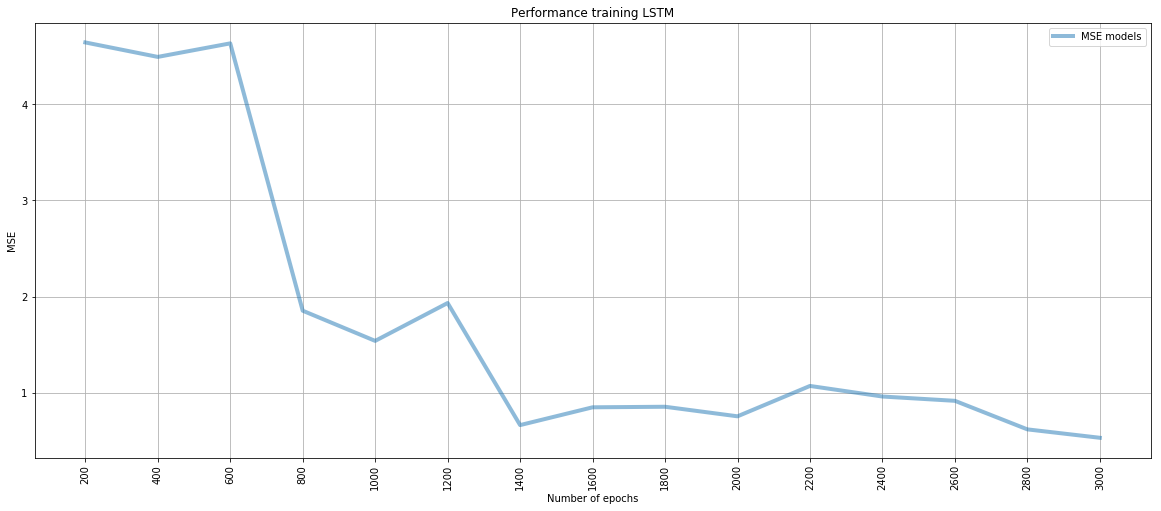

In [0]:
plot_metrics_model(LSTM_mse,list_epoch, "Performance training LSTM")

Observamos los distintos mse del modelo en diferentes momentos del entrenamiento:

In [0]:
columns = ['model', 'mse']
df_models = pd.DataFrame(columns=columns)
df_models['model'] = LSTM_combinations
df_models['mse'] = LSTM_mse
df_models

,model,mse
0,lstm 512 - look_back 30,4.642989
1,lstm 512 - look_back 30,4.492613
2,lstm 512 - look_back 30,4.633286
3,lstm 512 - look_back 30,1.853969
4,lstm 512 - look_back 30,1.540302
5,lstm 512 - look_back 30,1.933918
6,lstm 512 - look_back 30,0.664764
7,lstm 512 - look_back 30,0.849679
8,lstm 512 - look_back 30,0.855450
9,lstm 512 - look_back 30,0.756085


El mínimo se encuentra en la última etapa:

In [0]:
index_model_min_mse = df_models[df_models.mse == df_models.mse.min()].index[0]
look_back = df_models.loc[index_model_min_mse,'model']
look_back = int(look_back[look_back.rfind(" ")+1:])
print (index_model_min_mse, look_back)
df_models[df_models.mse == df_models.mse.min()]

14 30


,model,mse
14,lstm 512 - look_back 30,0.532882


In [0]:
X_train[look_back-1].shape

(30, 31)

Este modelo es utilizado para predecir los datos de entrenamiento:

In [0]:
model_lstm = LSTM_models[index_model_min_mse]
model_lstm.summary()
trainPredict = model_lstm.predict(X_train)
testPredict = model_lstm.predict(X_test)
trainPredict.shape, testPredict.shape

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 512)               1114112   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 1,114,625
Trainable params: 1,114,625
Non-trainable params: 0
_________________________________________________________________


((2160, 1), (518, 1))

Los resultados se observan en el siguiente gráfico:

In [35]:
Original_serie = scaler.fit_transform(data[:,2].reshape(-1, 1))
Original_serie.shape

(2738, 1)

In [0]:
x_lab1=[]
for i in range(Original_serie.shape[0]):
    x_lab1.append(i)
x_lab2=[]
for i in range(trainPredict.shape[0]):
    x_lab2.append(i)
x_lab3=[]
for i in range(trainPredict.shape[0]+60,Original_serie.shape[0]):
    x_lab3.append(i)

In [0]:
len(x_lab1), Original_serie.shape[0],len(x_lab2), trainPredict.shape[0],len(x_lab3), testPredict.shape[0]

(2738, 2738, 2160, 2160, 518, 518)

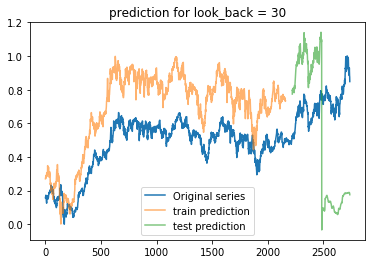

In [0]:
plt.plot(x_lab1,Original_serie, alpha=1, label='Original series');
plt.plot(x_lab2,trainPredict,alpha=0.6, label='train prediction');
plt.plot(x_lab3,testPredict, alpha=0.6, label='test prediction');
plt.title("prediction for look_back = 30")
plt.legend();

Observamos que, a pesar de que el mse es el más bajo entre los comparados, el modelo aún podría mejorar sus predicciones. 

Podría ser interesante observar cómo serían las predicciones del modelo con 1400 épocas de entrenamiento (se observa un valle en la gráfica de mse):

In [0]:
from keras.models import load_model
model1=Sequential()
model1.add(LSTM(512, input_shape=(30, X_train[0].shape[2])))
model1.add(Dense(1))
model1.compile(optimizer='adam',loss='mse')
model1.load_weights("/content/gdrive/My Drive/1_best_v2.hdf5")

In [32]:
model1.summary()
trainPredict = model1.predict(X_train)
testPredict = model1.predict(X_test)
trainPredict.shape, testPredict.shape

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 512)               1114112   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 1,114,625
Trainable params: 1,114,625
Non-trainable params: 0
_________________________________________________________________


((2160, 1), (518, 1))

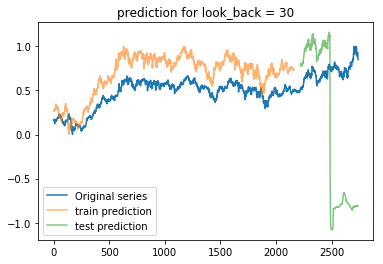

In [37]:
plt.plot(x_lab1,Original_serie, alpha=1, label='Original series');
plt.plot(x_lab2,trainPredict,alpha=0.6, label='train prediction');
plt.plot(x_lab3,testPredict, alpha=0.6, label='test prediction');
plt.title("prediction for look_back = 30")
plt.legend();

Observamos que, en la gráfica anterior, las predicciones se encuentran aún más alejadas de los valores del conjunto de datos de prueba. 

Como un último ejercicio, se entrenará nuevamente el modelo que obtuvo los mejores resultados, es decir, el que fue entrenado usando 3000 épocas. 
El modelo se entrenará por 1000 épocas más y graficaremos los resultados.

In [0]:
from keras.models import load_model
model1=Sequential()
model1.add(LSTM(512, input_shape=(30, X_train[0].shape[2])))
model1.add(Dense(1))
model1.compile(optimizer='adam',loss='mse')
model1.load_weights("/content/gdrive/My Drive/5_best_v3.hdf5")

In [0]:
LSTM_models=[]
LSTM_mse=[]

In [52]:
for i in range(2,5):
  print ('Entrenamiento',i+1)
  model1.fit(X_train, y_train[0].flatten(),epochs=200, verbose=1)
  pred = model1.predict(X_test)
  mse = mean_squared_error(y_test[0],pred)
  LSTM_models.append(model1), LSTM_mse.append(mse)
  model1.save_weights("/content/gdrive/My Drive/"+str(i+1)+"_best_v4.hdf5")

Entrenamiento 3
Epoch 1/200
2160/2160 [==============================] - 3s 1ms/step - loss: 8.2715e-06
Epoch 2/200
2160/2160 [==============================] - 3s 1ms/step - loss: 7.8319e-06
Epoch 3/200
2160/2160 [==============================] - 3s 1ms/step - loss: 7.7110e-06
Epoch 4/200
2160/2160 [==============================] - 3s 1ms/step - loss: 7.1128e-06
Epoch 5/200
2160/2160 [==============================] - 3s 1ms/step - loss: 6.4895e-06
Epoch 6/200
2160/2160 [==============================] - 3s 1ms/step - loss: 5.7593e-06
Epoch 7/200
2160/2160 [==============================] - 3s 1ms/step - loss: 4.0866e-06
Epoch 8/200
2160/2160 [==============================] - 3s 1ms/step - loss: 3.3289e-06
Epoch 9/200
2160/2160 [==============================] - 3s 1ms/step - loss: 3.1937e-06
Epoch 10/200
2160/2160 [==============================] - 3s 1ms/step - loss: 2.6965e-06
Epoch 11/200
2160/2160 [==============================] - 3s 1ms/step - loss: 2.2931e-06
Epoch 12/200
2

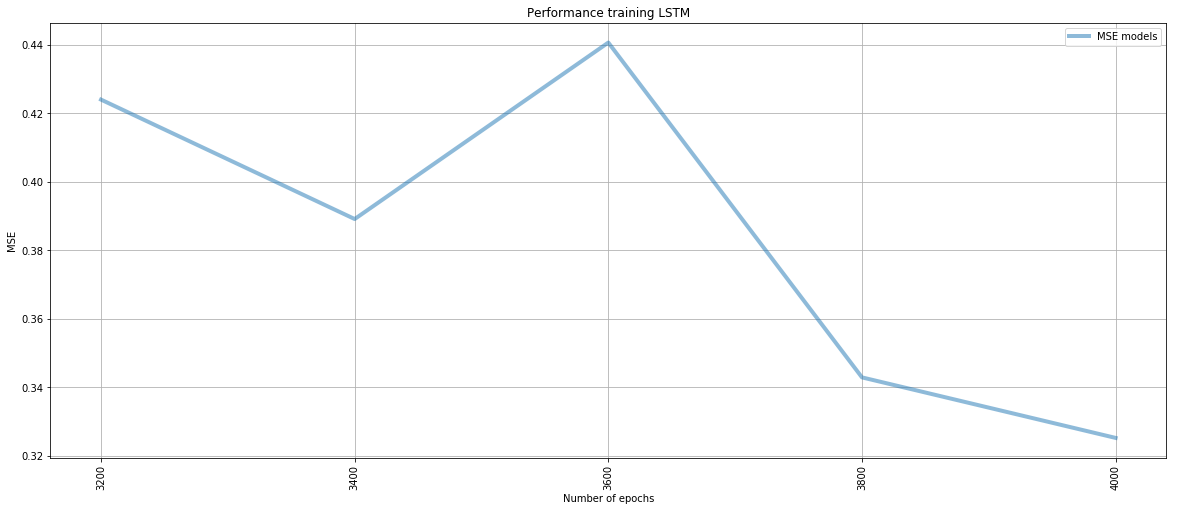

In [53]:
plot_metrics_model(LSTM_mse,[3200,3400,3600,3800,4000], "Performance training LSTM")

In [54]:
model1.summary()
trainPredict = model1.predict(X_train)
testPredict = model1.predict(X_test)
trainPredict.shape, testPredict.shape

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 512)               1114112   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 513       
Total params: 1,114,625
Trainable params: 1,114,625
Non-trainable params: 0
_________________________________________________________________


((2160, 1), (518, 1))

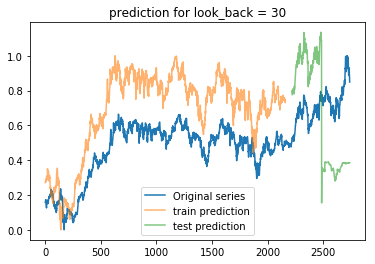

In [55]:
plt.plot(x_lab1,Original_serie, alpha=1, label='Original series');
plt.plot(x_lab2,trainPredict,alpha=0.6, label='train prediction');
plt.plot(x_lab3,testPredict, alpha=0.6, label='test prediction');
plt.title("prediction for look_back = 30")
plt.legend();

Por último, cambiaremos el optimizador a RMSprop y colocaemos un tamaño de batch de 64 para observar qué efecto tiene este cambio en el mse.

In [61]:
from keras.optimizers import RMSprop
optimizer=RMSprop(lr=0.001, rho=0.9, epsilon=1e-6)
model1.compile(optimizer=optimizer,loss='mse')
for i in range(1,5):
  print ('Entrenamiento',i+1)
  model1.fit(X_train, y_train[0].flatten(),epochs=200, batch_size=64,verbose=1)
  pred = model1.predict(X_test)
  mse = mean_squared_error(y_test[0],pred)
  LSTM_models.append(model1), LSTM_mse.append(mse)
  model1.save_weights("/content/gdrive/My Drive/"+str(i+1)+"_best_v5.hdf5")

Entrenamiento 2
Epoch 1/200
2160/2160 [==============================] - 2s 998us/step - loss: 5.7317e-05
Epoch 2/200
2160/2160 [==============================] - 1s 654us/step - loss: 4.0316e-05
Epoch 3/200
2160/2160 [==============================] - 1s 648us/step - loss: 3.5270e-05
Epoch 4/200
2160/2160 [==============================] - 1s 647us/step - loss: 2.9514e-05
Epoch 5/200
2160/2160 [==============================] - 1s 651us/step - loss: 4.6065e-05
Epoch 6/200
2160/2160 [==============================] - 1s 653us/step - loss: 3.4987e-05
Epoch 7/200
2160/2160 [==============================] - 1s 659us/step - loss: 4.0340e-05
Epoch 8/200
2160/2160 [==============================] - 1s 660us/step - loss: 3.4989e-05
Epoch 9/200
2160/2160 [==============================] - 1s 644us/step - loss: 3.5045e-05
Epoch 10/200
2160/2160 [==============================] - 1s 651us/step - loss: 4.1210e-05
Epoch 11/200
2160/2160 [==============================] - 1s 647us/step - loss: 3.9

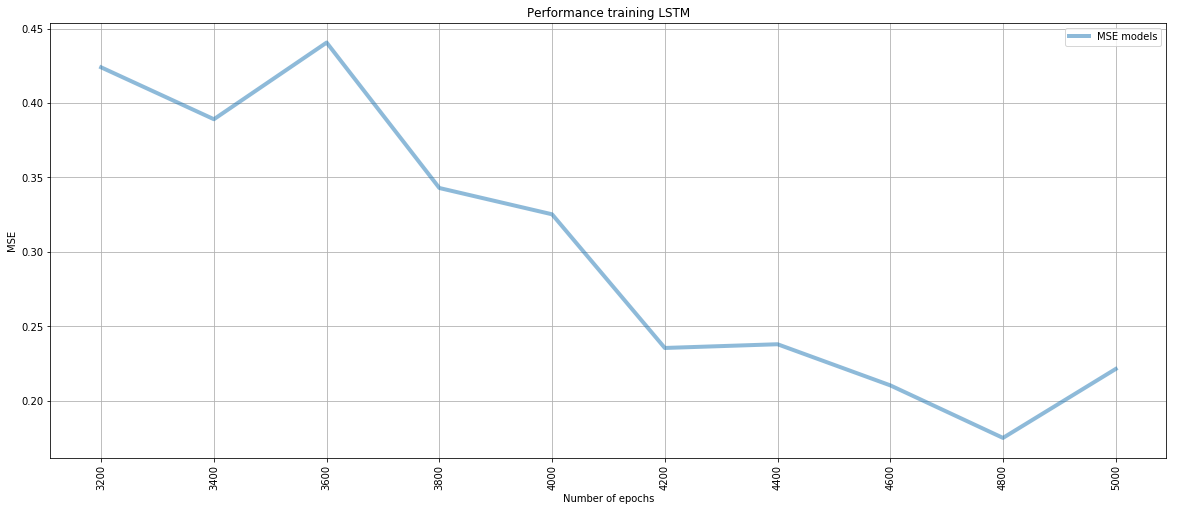

In [62]:
plot_metrics_model(LSTM_mse,[3200,3400,3600,3800,4000,4200,4400,4600,4800,5000], "Performance training LSTM")

In [69]:
columns = ['model', 'mse']
df_models = pd.DataFrame(columns=columns)
df_models['model'] = ['LSTM-Adam-3200','LSTM-Adam-3400','LSTM-Adam-3600','LSTM-Adam-3800','LSTM-Adam-4000','LSTM-RMSProp-batch64-4200','LSTM-RMSProp-batch64-4400','LSTM-RMSProp-batch64-4600','LSTM-RMSProp-batch64-4800','LSTM-RMSProp-batch64-5000']
df_models['mse'] = LSTM_mse
df_models

,model,mse
0,LSTM-Adam-3200,0.423939
1,LSTM-Adam-3400,0.389106
2,LSTM-Adam-3600,0.440586
3,LSTM-Adam-3800,0.342910
4,LSTM-Adam-4000,0.325254
5,LSTM-RMSProp-batch64-4200,0.235496
6,LSTM-RMSProp-batch64-4400,0.237997
7,LSTM-RMSProp-batch64-4600,0.210387
8,LSTM-RMSProp-batch64-4800,0.175097
9,LSTM-RMSProp-batch64-5000,0.221401


In [71]:
index_model_min_mse = df_models[df_models.mse == df_models.mse.min()].index[0]
print (index_model_min_mse)
df_models[df_models.mse == df_models.mse.min()]

8


,model,mse
8,LSTM-RMSProp-batch64-4800,0.175097


In [72]:
model_lstm = LSTM_models[index_model_min_mse]
model_lstm.summary()
trainPredict = model_lstm.predict(X_train)
testPredict = model_lstm.predict(X_test)
trainPredict.shape, testPredict.shape

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 512)               1114112   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 513       
Total params: 1,114,625
Trainable params: 1,114,625
Non-trainable params: 0
_________________________________________________________________


((2160, 1), (518, 1))

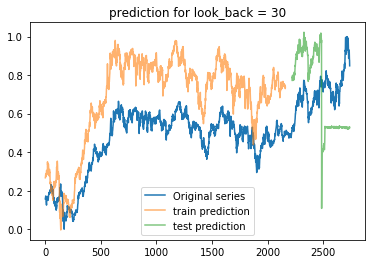

In [73]:
plt.plot(x_lab1,Original_serie, alpha=1, label='Original series');
plt.plot(x_lab2,trainPredict,alpha=0.6, label='train prediction');
plt.plot(x_lab3,testPredict, alpha=0.6, label='test prediction');
plt.title("prediction for look_back = 30")
plt.legend();

Luego de la última prueba, observamos que el mse bajó considerablemente. Tenemos un nuevo mínimo que es 0.175097.

Esto nos anima a realizar una última prueba para verificar si el mse podría serguir mejorando para este modelo.

In [74]:
from keras.optimizers import RMSprop
optimizer=RMSprop(lr=0.001, rho=0.9, epsilon=1e-6)
model1.compile(optimizer=optimizer,loss='mse')
for i in range(5):
  print ('Entrenamiento',i+1)
  model1.fit(X_train, y_train[0].flatten(),epochs=200, batch_size=64,verbose=1)
  pred = model1.predict(X_test)
  mse = mean_squared_error(y_test[0],pred)
  LSTM_models.append(model1), LSTM_mse.append(mse)
  model1.save_weights("/content/gdrive/My Drive/"+str(i+1)+"_best_v6.hdf5")

Entrenamiento 1
Epoch 1/200
2160/2160 [==============================] - 2s 1ms/step - loss: 3.1753e-05
Epoch 2/200
2160/2160 [==============================] - 1s 661us/step - loss: 2.1940e-05
Epoch 3/200
2160/2160 [==============================] - 1s 661us/step - loss: 2.2774e-05
Epoch 4/200
2160/2160 [==============================] - 1s 652us/step - loss: 1.8860e-05
Epoch 5/200
2160/2160 [==============================] - 1s 653us/step - loss: 2.7055e-05
Epoch 6/200
2160/2160 [==============================] - 1s 662us/step - loss: 2.3635e-05
Epoch 7/200
2160/2160 [==============================] - 1s 664us/step - loss: 2.3526e-05
Epoch 8/200
2160/2160 [==============================] - 1s 666us/step - loss: 2.1619e-05
Epoch 9/200
2160/2160 [==============================] - 1s 671us/step - loss: 2.0120e-05
Epoch 10/200
2160/2160 [==============================] - 1s 660us/step - loss: 2.1138e-05
Epoch 11/200
2160/2160 [==============================] - 1s 655us/step - loss: 2.192

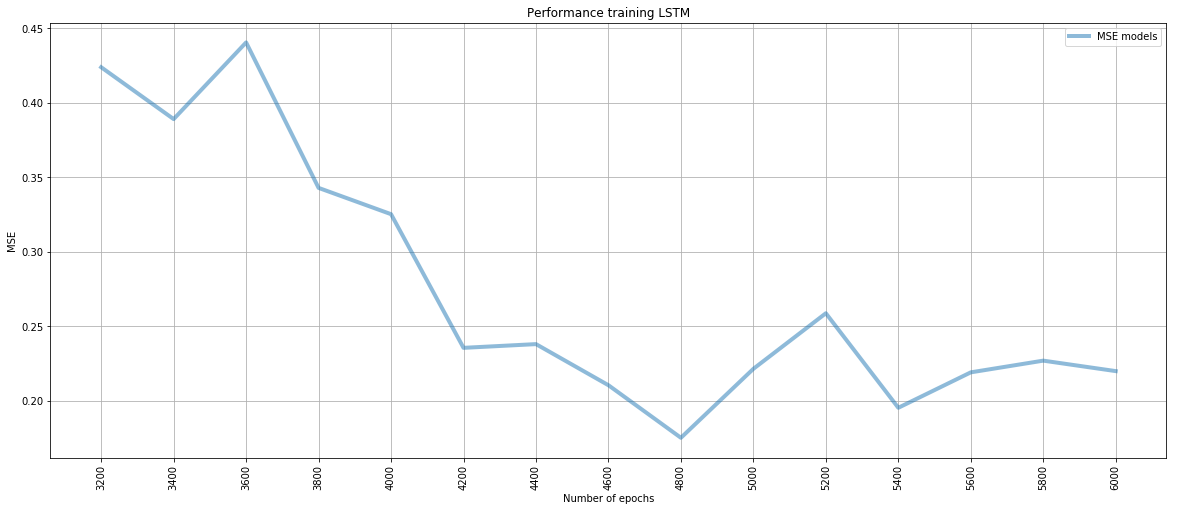

In [76]:
plot_metrics_model(LSTM_mse,[3200,3400,3600,3800,4000,4200,4400,4600,4800,5000,5200,5400,5600,5800,6000], "Performance training LSTM")

In [75]:
columns = ['model', 'mse']
df_models = pd.DataFrame(columns=columns)
df_models['model'] = ['LSTM-Adam-3200','LSTM-Adam-3400','LSTM-Adam-3600','LSTM-Adam-3800','LSTM-Adam-4000','LSTM-RMSProp-batch64-4200','LSTM-RMSProp-batch64-4400','LSTM-RMSProp-batch64-4600','LSTM-RMSProp-batch64-4800','LSTM-RMSProp-batch64-5000','LSTM-RMSProp-batch64-5200','LSTM-RMSProp-batch64-5400','LSTM-RMSProp-batch64-5600','LSTM-RMSProp-batch64-5800','LSTM-RMSProp-batch64-6000']
df_models['mse'] = LSTM_mse
df_models

,model,mse
0,LSTM-Adam-3200,0.423939
1,LSTM-Adam-3400,0.389106
2,LSTM-Adam-3600,0.440586
3,LSTM-Adam-3800,0.342910
4,LSTM-Adam-4000,0.325254
5,LSTM-RMSProp-batch64-4200,0.235496
6,LSTM-RMSProp-batch64-4400,0.237997
7,LSTM-RMSProp-batch64-4600,0.210387
8,LSTM-RMSProp-batch64-4800,0.175097
9,LSTM-RMSProp-batch64-5000,0.221401


In [77]:
index_model_min_mse = df_models[df_models.mse == df_models.mse.min()].index[0]
print (index_model_min_mse)
df_models[df_models.mse == df_models.mse.min()]

8


,model,mse
8,LSTM-RMSProp-batch64-4800,0.175097


In [78]:
model_lstm = LSTM_models[index_model_min_mse]
model_lstm.summary()
trainPredict = model_lstm.predict(X_train)
testPredict = model_lstm.predict(X_test)
trainPredict.shape, testPredict.shape

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 512)               1114112   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 513       
Total params: 1,114,625
Trainable params: 1,114,625
Non-trainable params: 0
_________________________________________________________________


((2160, 1), (518, 1))

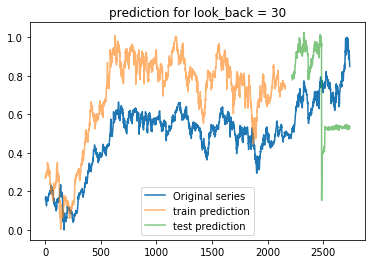

In [79]:
plt.plot(x_lab1,Original_serie, alpha=1, label='Original series');
plt.plot(x_lab2,trainPredict,alpha=0.6, label='train prediction');
plt.plot(x_lab3,testPredict, alpha=0.6, label='test prediction');
plt.title("prediction for look_back = 30")
plt.legend();

De acuerdo a los resultados, se logró obtener un mse de 0.175097. Cabe resaltar que este valor corresponde a los datos escalados. 

In [0]:
Original=scaler.inverse_transform(Original_serie)
TrainP=scaler.inverse_transform(trainPredict)
TestP=scaler.inverse_transform(testPredict)

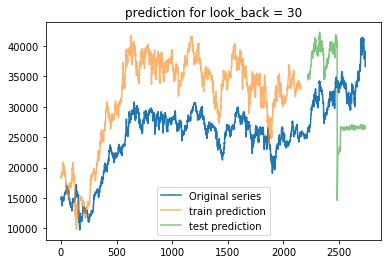

In [81]:
plt.plot(x_lab1,Original, alpha=1, label='Original series');
plt.plot(x_lab2,TrainP,alpha=0.6, label='train prediction');
plt.plot(x_lab3,TestP, alpha=0.6, label='test prediction');
plt.title("prediction for look_back = 30")
plt.legend();

In [83]:
mse = mean_squared_error(scaler.inverse_transform(y_test[0]),TestP)
mse

220806192.2124267

El mse real podría ser mucho mejor.